# Big Data Project

## Collecting the data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"adityagavankar","key":"a88b99f26263bb4a9d14c8a37a21cbdb"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d hotsonhonet/amex-competition

amex-competition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip -qq "/content/amex-competition.zip"

replace dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 50.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=3e92d57b71a1e4f22fced1ab4d2d8e4bead6e1bb07a52854e0a6d97b0c30e03a
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import random
import numpy as np
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct

In [ ]:
spark = SparkSession.builder.appName('Dataframe').getOrCreate()
df = spark.read.csv('/content/dataset/train.csv', header = True, inferSchema = True)

## Data exploration / cleaning

In [ ]:
df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- owns_car: string (nullable = true)
 |-- owns_house: string (nullable = true)
 |-- no_of_children: double (nullable = true)
 |-- net_yearly_income: double (nullable = true)
 |-- no_of_days_employed: double (nullable = true)
 |-- occupation_type: string (nullable = true)
 |-- total_family_members: double (nullable = true)
 |-- migrant_worker: double (nullable = true)
 |-- yearly_debt_payments: double (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- credit_limit_used(%): integer (nullable = true)
 |-- credit_score: double (nullable = true)
 |-- prev_defaults: integer (nullable = true)
 |-- default_in_last_6months: integer (nullable = true)
 |-- credit_card_default: integer (nullable = true)



In [ ]:
df.dtypes

[('customer_id', 'string'),
 ('name', 'string'),
 ('age', 'int'),
 ('gender', 'string'),
 ('owns_car', 'string'),
 ('owns_house', 'string'),
 ('no_of_children', 'double'),
 ('net_yearly_income', 'double'),
 ('no_of_days_employed', 'double'),
 ('occupation_type', 'string'),
 ('total_family_members', 'double'),
 ('migrant_worker', 'double'),
 ('yearly_debt_payments', 'double'),
 ('credit_limit', 'double'),
 ('credit_limit_used(%)', 'int'),
 ('credit_score', 'double'),
 ('prev_defaults', 'int'),
 ('default_in_last_6months', 'int'),
 ('credit_card_default', 'int')]

In [ ]:
df.describe().show()

+-------+-----------+------+----------------+------+--------+----------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+------------------+--------------------+-----------------------+-------------------+
|summary|customer_id|  name|             age|gender|owns_car|owns_house|    no_of_children| net_yearly_income|no_of_days_employed|     occupation_type|total_family_members|     migrant_worker|yearly_debt_payments|      credit_limit|credit_limit_used(%)|      credit_score|       prev_defaults|default_in_last_6months|credit_card_default|
+-------+-----------+------+----------------+------+--------+----------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+------------------+--------------------+-----------------------+-------

In [ ]:
df=df.drop("name")
df=df.drop("customer_id")
df.show()

+---+------+--------+----------+--------------+-----------------+-------------------+--------------------+--------------------+--------------+--------------------+------------+--------------------+------------+-------------+-----------------------+-------------------+
|age|gender|owns_car|owns_house|no_of_children|net_yearly_income|no_of_days_employed|     occupation_type|total_family_members|migrant_worker|yearly_debt_payments|credit_limit|credit_limit_used(%)|credit_score|prev_defaults|default_in_last_6months|credit_card_default|
+---+------+--------+----------+--------------+-----------------+-------------------+--------------------+--------------------+--------------+--------------------+------------+--------------------+------------+-------------+-----------------------+-------------------+
| 46|     F|       N|         Y|           0.0|        107934.04|              612.0|             Unknown|                 1.0|           1.0|            33070.28|    18690.93|                 

In [ ]:
df=df.na.drop()

In [ ]:
psdf=df.toPandas()
psdf

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43504,55,F,N,N,2.0,96207.57,117.0,Unknown,4.0,0.0,11229.54,29663.83,82,907.0,0,0,0
43505,31,F,N,Y,0.0,383476.74,966.0,Accountants,2.0,1.0,43369.91,139947.16,32,679.0,0,0,0
43506,27,F,N,Y,0.0,260052.18,1420.0,Core staff,2.0,0.0,22707.51,83961.83,46,727.0,0,0,0
43507,32,M,Y,N,0.0,157363.04,2457.0,Laborers,2.0,0.0,20150.10,25538.72,92,805.0,0,0,0


## Data Preparation

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [ ]:
categoricalColumns = ['gender','owns_car','owns_house','occupation_type','total_family_members', 'migrant_worker', 'prev_defaults', 'default_in_last_6months','no_of_children']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [ ]:
label_stringIdx = StringIndexer(inputCol = 'credit_card_default', outputCol = 'label')
stages += [label_stringIdx]

In [ ]:
numericCols = ['age', 'credit_limit_used(%)', 'default_in_last_6months','net_yearly_income','no_of_days_employed','yearly_debt_payments','credit_limit','credit_score']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- owns_car: string (nullable = true)
 |-- owns_house: string (nullable = true)
 |-- no_of_children: double (nullable = true)
 |-- net_yearly_income: double (nullable = true)
 |-- no_of_days_employed: double (nullable = true)
 |-- occupation_type: string (nullable = true)
 |-- total_family_members: double (nullable = true)
 |-- migrant_worker: double (nullable = true)
 |-- yearly_debt_payments: double (nullable = true)
 |-- credit_limit: double (nullable = true)
 |-- credit_limit_used(%): integer (nullable = true)
 |-- credit_score: double (nullable = true)
 |-- prev_defaults: integer (nullable = true)
 |-- default_in_last_6months: integer (nullable = true)
 |-- credit_card_default: integer (nullable = true)



In [ ]:
cols = df.columns

In [ ]:
df.dtypes

[('age', 'int'),
 ('gender', 'string'),
 ('owns_car', 'string'),
 ('owns_house', 'string'),
 ('no_of_children', 'double'),
 ('net_yearly_income', 'double'),
 ('no_of_days_employed', 'double'),
 ('occupation_type', 'string'),
 ('total_family_members', 'double'),
 ('migrant_worker', 'double'),
 ('yearly_debt_payments', 'double'),
 ('credit_limit', 'double'),
 ('credit_limit_used(%)', 'int'),
 ('credit_score', 'double'),
 ('prev_defaults', 'int'),
 ('default_in_last_6months', 'int'),
 ('credit_card_default', 'int')]

In [ ]:
train, test = df.randomSplit([0.7,0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 30453
Test Dataset Count: 13056


## Building a model

### Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
lr_predictions = lrModel.transform(test)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.9803155637254902


In [ ]:
predictions = lrModel.transform(test)
predictions.select('age','label','rawPrediction', 'prediction', 'probability').show(10)

+---+-----+--------------------+----------+--------------------+
|age|label|       rawPrediction|prediction|         probability|
+---+-----+--------------------+----------+--------------------+
| 23|  0.0|[11.9436792896960...|       0.0|[0.99999349985315...|
| 23|  0.0|[12.3267822941192...|       0.0|[0.99999556856334...|
| 23|  0.0|[15.0439964205396...|       0.0|[0.99999970726460...|
| 23|  0.0|[15.0762205184342...|       0.0|[0.99999971654736...|
| 23|  0.0|[12.5124913449120...|       0.0|[0.99999631962174...|
| 23|  0.0|[10.8640282909817...|       0.0|[0.99998086607126...|
| 23|  0.0|[16.3994576772896...|       0.0|[0.99999992452450...|
| 23|  0.0|[13.0071376280162...|       0.0|[0.99999775575157...|
| 23|  0.0|[7.06310424088713...|       0.0|[0.99914461593495...|
| 23|  0.0|[16.9177808636187...|       0.0|[0.99999995505295...|
+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.993551697708787


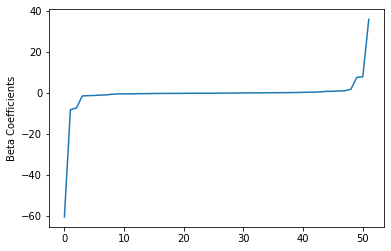

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


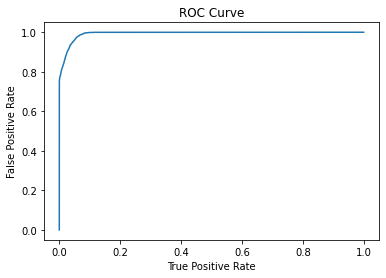

Training set areaUnderROC: 0.9934921654471327


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


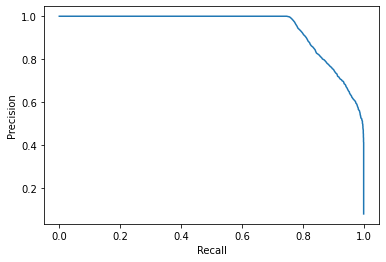

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Decision Tree Algorithm

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age','label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----+---------------+----------+--------------------+
|age|label|  rawPrediction|prediction|         probability|
+---+-----+---------------+----------+--------------------+
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
| 23|  0.0|[28007.0,605.0]|       0.0|[0.97885502586327...|
+---+-----+---------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Decision Tree Accuracy:', multi_evaluator.evaluate(predictions))

Decision Tree Accuracy: 0.9813878676470589


In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8880184331797235


### Random Forest Algorithm

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----+--------------------+----------+--------------------+
|age|label|       rawPrediction|prediction|         probability|
+---+-----+--------------------+----------+--------------------+
| 23|  0.0|[19.5875790442663...|       0.0|[0.97937895221331...|
| 23|  0.0|[19.5140209688238...|       0.0|[0.97570104844119...|
| 23|  0.0|[19.6858084338143...|       0.0|[0.98429042169071...|
| 23|  0.0|[19.6134326093641...|       0.0|[0.98067163046820...|
| 23|  0.0|[19.6106587110083...|       0.0|[0.98053293555041...|
| 23|  0.0|[19.5056639960183...|       0.0|[0.97528319980091...|
| 23|  0.0|[19.6806610494194...|       0.0|[0.98403305247097...|
| 23|  0.0|[19.6134326093641...|       0.0|[0.98067163046820...|
| 23|  0.0|[19.6134326093641...|       0.0|[0.98067163046820...|
| 23|  0.0|[19.5140209688238...|       0.0|[0.97570104844119...|
+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Random Forest Accuracy:', multi_evaluator.evaluate(predictions))

Random Forest Accuracy: 0.9800091911764706


In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9934335550545151


### Gradient Boosting Algorithm

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----+--------------------+----------+--------------------+
|age|label|       rawPrediction|prediction|         probability|
+---+-----+--------------------+----------+--------------------+
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
| 23|  0.0|[1.32590702962262...|       0.0|[0.93412271108032...|
| 23|  0.0|[1.32590267922038...|       0.0|[0.93412217565278...|
+---+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Gradient Boosting Accuracy:', multi_evaluator.evaluate(predictions))

Gradient Boosting Accuracy: 0.9809283088235294


In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9953896263127442


Here, the Gradient-Boosted Tree achieved the best results

## Final prediction / Hyper tuning the model

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Running cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9951418308531331